In this notebook, some models are trained on kaggle production plant dataset using the automated pipeline

In [3]:
import warnings 
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from utilities import *
from sklearn.metrics import mean_squared_error
import os
from datetime import datetime
import rul 
%load_ext autoreload
%autoreload

# Load Data

In [4]:
kaggle_data = pd.read_csv("C:\\Users\\I539001\\OneDrive - SAP SE\\PA2\\AL\\FeedbackBoost\\Data\\Kaggle_Plant.csv")

In [5]:
kaggle_data.shape

(228412, 34)

In [6]:
Data_id = "Kaggel_plant"

In [7]:
kaggle_data

,Unnamed: 0,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,...,L_10,A_5,B_5,C_5,ts_int,cnt_per_rtf,RUL,RUL_pw,phase,IMM_FAILURE
0,1,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,...,-65.524273,-100.0,-100.0,-100.0,1,51671,51671,120,1,0
1,2,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,...,-65.524273,-100.0,-100.0,-100.0,2,51671,51670,120,1,0
2,3,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,...,-71.139518,-100.0,-100.0,-100.0,3,51671,51669,120,1,0
3,4,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,...,-68.708337,-100.0,-100.0,-100.0,4,51671,51668,120,1,0
4,5,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,...,-67.030037,-100.0,-100.0,-100.0,5,51671,51667,120,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228407,228408,16,21016,-91.921033,-54.939729,-12.645781,-24.723005,-22.313266,-24.747541,-22.298259,...,-30.123128,-100.0,-100.0,-100.0,228420,21021,5,5,3,1
228408,228409,16,21017,-99.331815,-79.731577,-12.706761,-24.762342,-22.448703,-24.813115,-22.284708,...,-60.269783,-100.0,-100.0,-100.0,228421,21021,4,4,3,1
228409,228410,16,21018,-99.331815,-79.731577,-12.706761,-24.736117,-22.313266,-24.826230,-22.271157,...,-59.062034,-100.0,-100.0,-100.0,228422,21021,3,3,3,1
228410,228411,16,21019,-99.331815,-79.731577,-12.462840,-24.893464,-22.380985,-24.865574,-22.284708,...,-61.242256,-100.0,-100.0,-100.0,228423,21021,2,2,3,1


In [8]:
kaggel_data_uncleaned = kaggle_data.copy()

# Some Exploratory Analysis

In [9]:
kaggle_data['rtf_id'].unique() # here we can see how little data we actually have (too few rtf_ids)

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

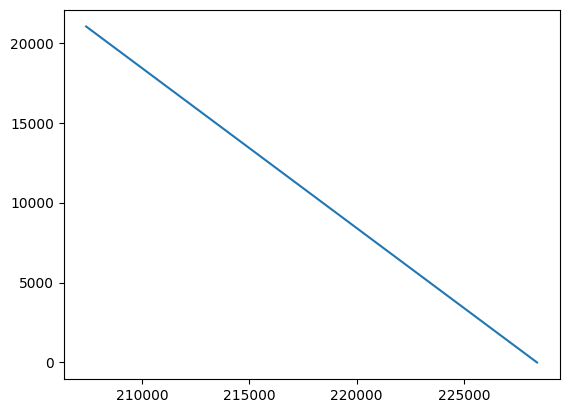

In [10]:
data_16 = kaggle_data[kaggle_data['rtf_id'] == 16] 
plt.plot(data_16["RUL"])

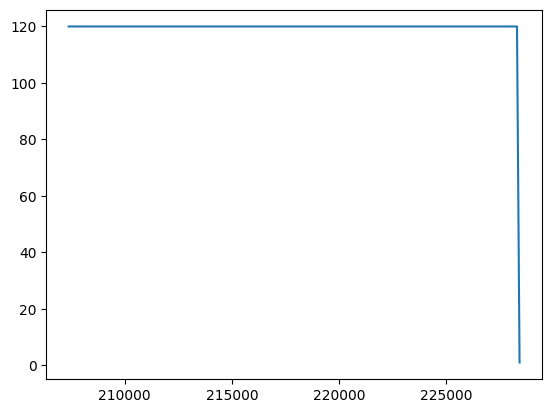

In [11]:
fig = plt.figure()
# plt.rcParams["figure.figsize"] = (50,20)
# fig, ax = plt.subplots()
# ratio = 2
# x_left, x_right = ax.get_xlim()
# y_low, y_high = ax.get_ylim()
# ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.plot(data_16["RUL_pw"])


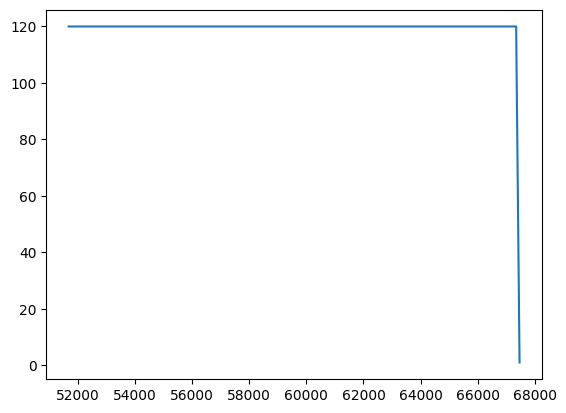

In [12]:
data_8 = kaggle_data[kaggle_data['rtf_id'] == 8]
fig = plt.figure()
# plt.rcParams["figure.figsize"] = (50,10)
# fig, ax = plt.subplots()

# ratio = 2
# x_left, x_right = ax.get_xlim()
# y_low, y_high = ax.get_ylim()
# ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)
plt.plot(data_8["RUL_pw"])

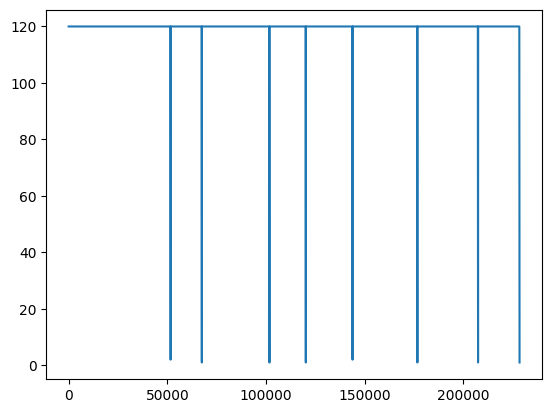

In [13]:
plt.plot(kaggle_data["RUL_pw"])

In [14]:
# we only have 8 rtfs -> very few amount of data
rtf_ids = kaggle_data['rtf_id'].unique() # very few amount of data compared to cmaps (260 unique engine_ids alone in train set)
rtf_ids
# cross validation as solution to "zu wenig data"?

array([ 7,  8,  9, 11, 13, 14, 15, 16], dtype=int64)

# Data Preparation

# Train Data

In [15]:
kaggle_data= kaggle_data.drop(['Unnamed: 0', 'ts_int', 'cnt_per_rtf','phase','IMM_FAILURE'], axis=1) 
# run to failure id: z.B engine_id 

In [16]:
#define train dataset and test dataset: first, without cross validation. Just manually defining
train_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[:6]))]
train_data.head()

,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5,RUL,RUL_pw
0,7,0,-99.331815,-79.731577,-49.996189,-56.874058,-55.671430,-57.022951,-55.660953,-57.035192,...,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.0,-100.0,51671,120
1,7,1,-99.331815,-79.731577,-50.087659,-56.874058,-55.617255,-56.970492,-55.498340,-57.087620,...,-84.311211,-93.610953,-25.438393,-97.509680,-65.524273,-100.0,-100.0,-100.0,51670,120
2,7,2,-96.142749,-71.343358,-50.118149,-56.978955,-55.603711,-57.140984,-55.538993,-57.048299,...,-84.311211,-93.610953,-23.687395,-97.509680,-71.139518,-100.0,-100.0,-100.0,51669,120
3,7,3,-88.883827,-59.724121,-50.102904,-56.874058,-55.671430,-56.983607,-55.593197,-57.035192,...,-84.311211,-85.852824,-12.887859,-89.826133,-68.708337,-100.0,-100.0,-100.0,51668,120
4,7,4,-66.985573,-50.316888,-50.148639,-56.992067,-55.590167,-57.062295,-55.674504,-57.035192,...,-84.311211,-65.288078,-10.575512,-67.853618,-67.030037,-100.0,-100.0,-100.0,51667,120


In [17]:
train_data_with_original_pw_rul = train_data.copy()

In [18]:
train_data = train_data.drop(["RUL_pw"], axis = 1)

In [19]:
train_RUL_per_rtf_id =  extract_RUL_per_rtf_id(train_data, rul_column_name= "RUL")
train_RUL_per_rtf_id

,rtf_id,rul_per_rtf_id
0,7,2
1,8,1
2,9,1
3,11,1
4,13,2
5,14,1


In [20]:
x_train_data = train_data.loc[:, train_data.columns!='RUL']

# Test Data

In [21]:
test_data = kaggle_data.loc[kaggle_data['rtf_id'].isin(list(rtf_ids[6:]))]

In [22]:
test_data_with_original_pw_rul = test_data.copy()

In [23]:
test_data = test_data.drop(["RUL_pw"], axis = 1)

In [24]:
test_RUL_per_rtf_id = extract_RUL_per_rtf_id(test_data, rul_column_name= "RUL")
test_RUL_per_rtf_id

,rtf_id,rul_per_rtf_id
0,15,1
1,16,1


In [25]:
x_test_data = test_data.loc[:, test_data.columns!='RUL']
x_test_data.head()


,rtf_id,cycle,L_1,L_2,A_1,A_2,B_1,B_2,C_1,C_2,...,L_4,L_5,L_6,L_7,L_8,L_9,L_10,A_5,B_5,C_5
176658,15,0,-96.795748,-71.268796,-49.996189,-57.214974,-55.739148,-57.114754,-55.511891,-57.022085,...,-97.493393,-75.136673,-81.489794,-93.297205,-25.016094,-97.297092,-64.834131,-100.0,-100.0,-100.0
176659,15,1,-74.624146,-62.209519,-50.163884,-57.083852,-55.657886,-56.983607,-55.525442,-57.035192,...,-75.069834,-68.291770,-81.489794,-72.005134,-21.812798,-74.762736,-78.715395,-100.0,-100.0,-100.0
176660,15,2,-49.673500,-56.965329,-50.102904,-57.110077,-55.617255,-56.904918,-55.566095,-57.113834,...,-50.426569,-59.889163,-81.489794,-52.481460,-30.269087,-49.889910,-71.861031,-100.0,-100.0,-100.0
176661,15,3,4.920273,-40.859948,-50.133394,-57.083852,-55.549536,-56.891803,-55.484789,-57.008978,...,4.552677,-31.461095,-81.489794,3.009127,-5.003219,5.489333,-38.012705,-100.0,-100.0,-100.0
176662,15,4,75.018983,-38.461538,-50.041924,-57.228086,-55.603711,-56.931148,-55.660953,-57.126941,...,73.363560,-36.194114,-81.489794,73.060439,-11.523111,74.808291,-19.269077,-100.0,-100.0,-100.0


## Computing Remaining Useful Life

In [26]:
import importlib
import rul
importlib.reload(rul)


<module 'rul' from 'c:\\Users\\I539001\\OneDrive - SAP SE\\PA2\\AL\\AutoRUL\\rul.py'>

In [27]:
test_RUL_per_rtf_id = test_RUL_per_rtf_id["rul_per_rtf_id"]
train_RUL_per_rtf_id = train_RUL_per_rtf_id["rul_per_rtf_id"]

In [28]:
train_RUL_per_rtf_id

0    2
1    1
2    1
3    1
4    2
5    1
Name: rul_per_rtf_id, dtype: int64

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
16970  16970
16971  16971
16972  16972
16973  16972
16974  16973
16975  16974


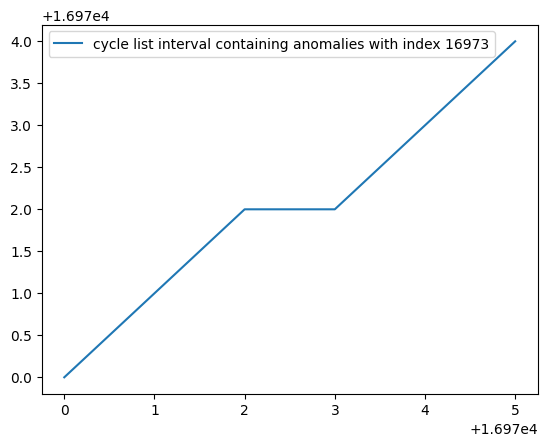

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
26104  26103
26105  26104
26106  26105
26107  26110
26108  26111
26109  26112


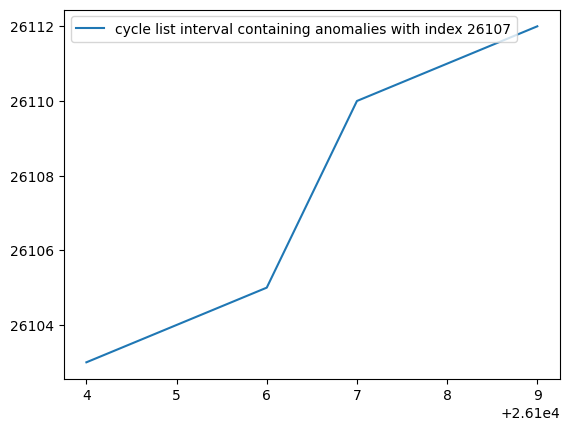

the interval in the cycles with anomalies (for rtf_id = 5):        cycle
19746  19746
19747  19747
19748  19748
19749  19748
19750  19749
19751  19750


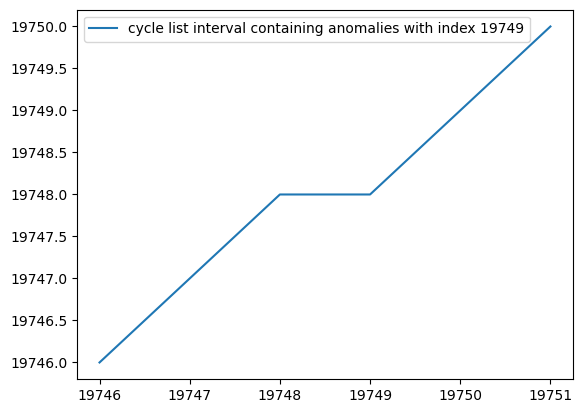

the interval in the cycles with anomalies (for rtf_id = 6):        cycle
18809  18809
18810  18810
18811  18811
18812  18816
18813  18817
18814  18818


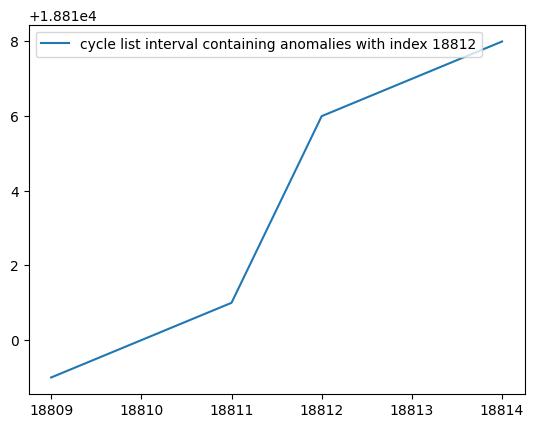

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
15911  15911
15912  15912
15913  15913
15914  15918
15915  15919
15916  15920


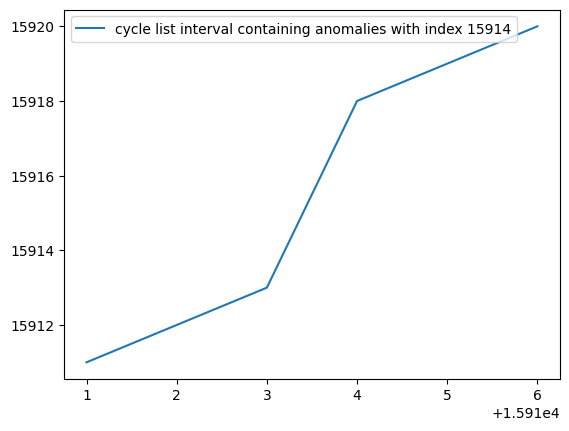

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
16970  16970
16971  16971
16972  16972
16973  16972
16974  16973
16975  16974


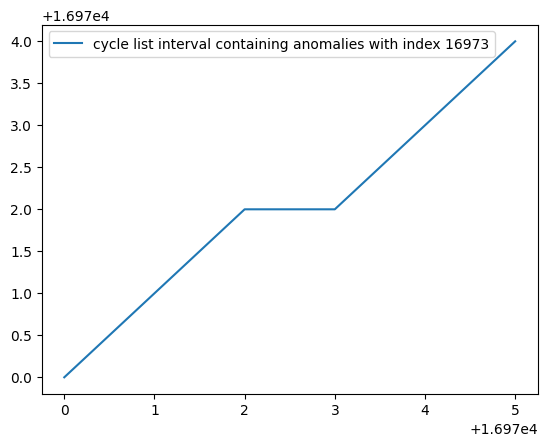

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
26104  26103
26105  26104
26106  26105
26107  26110
26108  26111
26109  26112


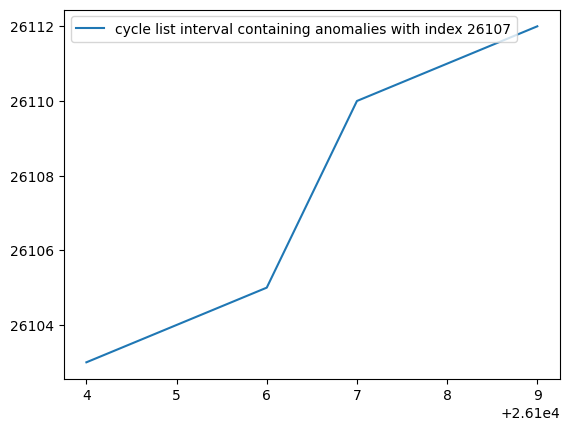

the interval in the cycles with anomalies (for rtf_id = 5):        cycle
19746  19746
19747  19747
19748  19748
19749  19748
19750  19749
19751  19750


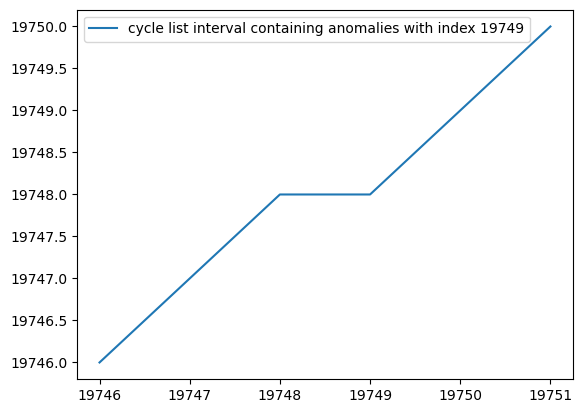

the interval in the cycles with anomalies (for rtf_id = 6):        cycle
18809  18809
18810  18810
18811  18811
18812  18816
18813  18817
18814  18818


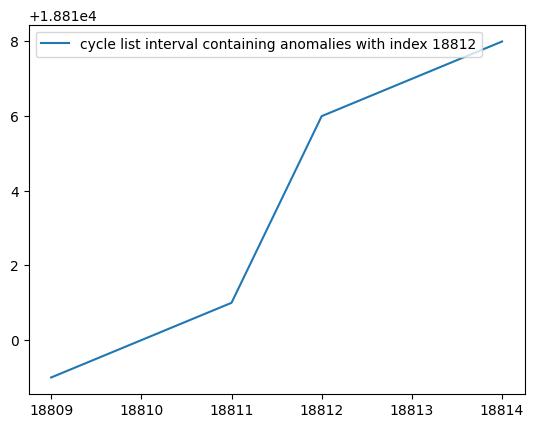

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
15911  15911
15912  15912
15913  15913
15914  15918
15915  15919
15916  15920


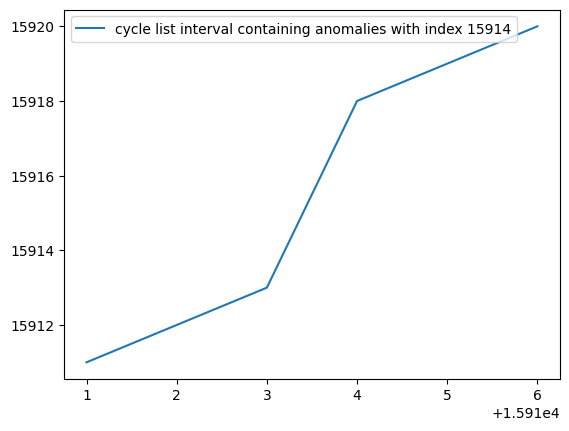

valid Configuration!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrapp  (None, 5, 12, 1, 10)     6980      
 er)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 12, 1, 10)     40        
 ormalization)                                                   
                                                                 
 module_wrapper_1 (ModuleWra  (None, 8, 1, 20)         18160     
 pper)                                                           
                                                                 
 batch_normalization_1 (Batc  (None, 8, 1, 20)         80        
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None,

KeyboardInterrupt: 

In [29]:
test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=12000, epochs= 30)
test.auto_rul()

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
16970  16970
16971  16971
16972  16972
16973  16972
16974  16973
16975  16974


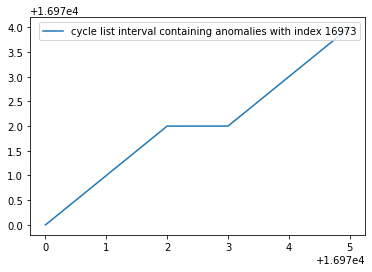

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
26104  26103
26105  26104
26106  26105
26107  26110
26108  26111
26109  26112


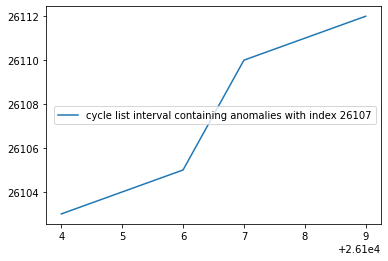

the interval in the cycles with anomalies (for rtf_id = 5):        cycle
19746  19746
19747  19747
19748  19748
19749  19748
19750  19749
19751  19750


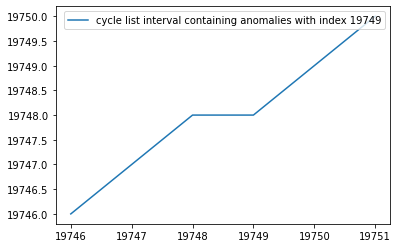

the interval in the cycles with anomalies (for rtf_id = 6):        cycle
18809  18809
18810  18810
18811  18811
18812  18816
18813  18817
18814  18818


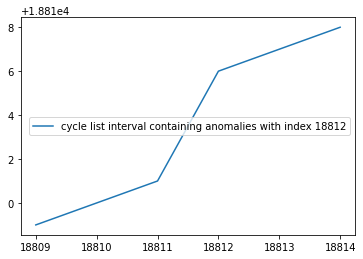

the interval in the cycles with anomalies (for rtf_id = 1):        cycle
15911  15911
15912  15912
15913  15913
15914  15918
15915  15919
15916  15920


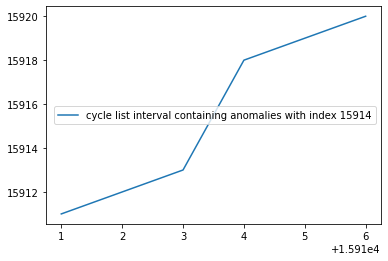

training (176658, 25) (176658,)
testing (51754, 25) (51754,)


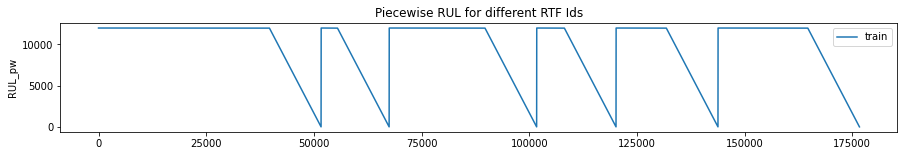

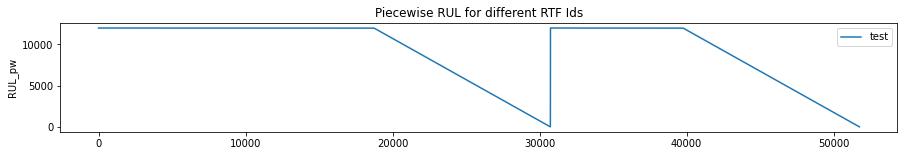

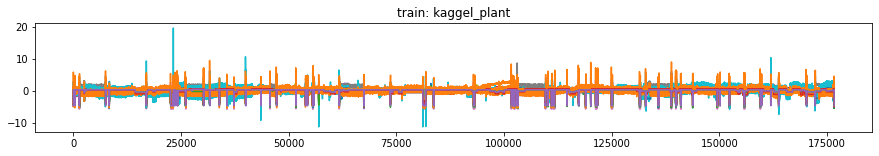

In [ ]:
test  = rul.RemainingUsefulLife(x_train_data,x_test_data,test_RUL_per_rtf_id, train_rul_per_rtf_id= train_RUL_per_rtf_id,max_life=12000, epochs= 30)

test.plot_rul()